## Local chiral potentials

We use here the local chiral potentials [GT+](https://arxiv.org/abs/1406.0454) up to N2LO, which are commonly used in quantum Monte Carlo (QMC) calculations of finite nuclei and infinite matter. 

We have developed an affine decomposed version of the original `C++` source code provided by the developers. It matches the original, non-affine decomposed version of the code very well.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import numpy as np
import matplotlib.pyplot as plt
from Potential import Potential, chiral, chiral_affine
from Channel import Channel

In [13]:
potentialArgs = {"label": "chiral", "kwargs": {"potId": 233}}
l = 0
channel = Channel(S=1, L=2, LL=2, J=1, channel=0)
potential = Potential(channel, **potentialArgs)
r = 1.
aff_decomp = chiral_affine(r, channel, **potentialArgs["kwargs"])
aff_decomp

array([  -5.53041341,   15.31411662,   15.31411662, -102.3864922 ,
        307.15947659, -102.3864922 ,  307.15947659, -140.04679124,
        220.85788572, -662.57365715,    0.        ,    0.        ])

In [5]:
import yaml
with open("data/localGT+_lecs_order_2_R0_0.9_lam_1000.yaml", 'r') as stream:
    lecs = yaml.safe_load(stream)
lecs

{'potId': 233,
 'order': 2,
 'R0': 0.9,
 'lambda': 1000,
 'CS': 7.74784,
 'CNN': 0.04164,
 'CPP': 0.06329,
 'CT': 0.45247,
 'C1': -0.21715,
 'C2': 0.03457,
 'C3': -0.11535,
 'C4': 0.11818,
 'C5': -2.41603,
 'C6': 0.15463,
 'C7': -0.26709}

In [6]:
lec_vec = np.array([1.] + [lecs[elem] for elem in ("CS", "CT", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "CNN", "CPP")])
potval_via_aff_decomp = aff_decomp @ lec_vec

In [7]:
potval = chiral(r, channel, **lecs)
diff = potval_via_aff_decomp - potval
assert diff < 1e-13, f"difference (aff. vs. nonaffine evaluation): {diff:e} MeV"

Text(0, 0.5, 'V(r) [fm$^{-1}$]')

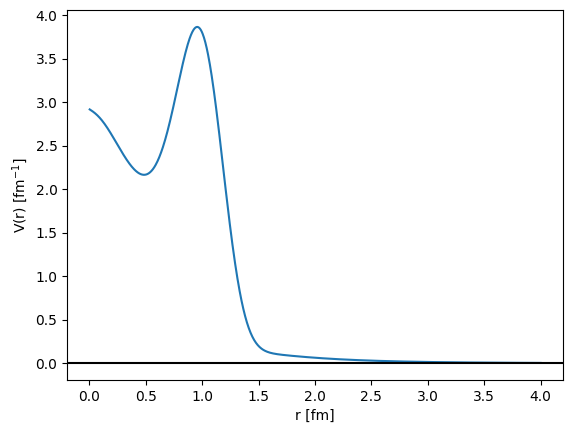

In [14]:
hbarc = 197.326
rarr = np.linspace(0., 4., 1000)
yarr = np.array([chiral(r, channel, **lecs) for r in rarr])
plt.plot(rarr, yarr / hbarc)
plt.axhline(0, c="k")
plt.xlabel("r [fm]")
plt.ylabel("V(r) [fm$^{-1}$]")

In [ ]:
for (S, L, LL, J, mT) in product(S_arr, L_arr, LL_arr, J_arr, mT_arr):
    try:
        channel = Channel(S=S, L=L, LL=LL, J=J, channel=mT)
    except ValueError:
        continue  # ignore unphysical pw channel
    
    with open("data/localGT+_lecs_order_2_R0_0.9_lam_1000.yaml", 'r') as stream:
        lecs = yaml.safe_load(stream)
    lec_vec = np.array([1.] + [lecs[elem] for elem in lec_lbls])
    
    for r in np.random.uniform(low=1e-3, high=4., size=1000):
        aff_decomp = chiral_affine(r, channel, **potentialArgs["kwargs"])
        potval_via_aff_decomp = aff_decomp @ lec_vec
        potval = chiral(r, channel, **lecs)
        assert np.allclose(potval_via_aff_decomp, potval, atol=1e-12, rtol=0.), \
            f"difference (aff. vs. nonaffine evaluation): {potval_via_aff_decomp - potval:e} MeV"

## Transforming low-energy constants (LECs)

The (Lagrangian) low-energery constants (LECs) $C_S, C_T,$ and $C_{1-7}$ were fit to NN phase shifts. In every partial wave only certain LECs contribute. In the following we give the partial 
wave decomposition for all relevant channels. We use spectroscopic LECs given in terms of $C_S, C_T,$ and $C_{1-7}$ as follows:

\begin{align}
d_{11}^{(np)} & =C_S^{(np)} + C_T \,,  \\
d_{22}^{(m_T)} & =C_S^{(m_T)}-3C_T \,, \quad m_T = \text{np}, \, \text{nn}, \, \text{pp}\\
d_{1} & =C_1-3C_2+C_3-3C_4 \,, \\
d_{2} & =C_6-3C_7 \,, \\
d_{3} & =C_1+C_2-3C_3-3C_4 \,, \\
d_{4} & =C_1+C_2+C_3+C_4 \,, \\
d_{5} & =C_1-3C_2-3C_3+9C_4 \,, \\
d_{6} & =\frac{1}{2} C_5 \,, \\
d_{7} & = C_6+C_7\,. 
\end{align}

Note that $C_S$ include isospin symmetry breaking effects. The authors defined:

$$
C_S^{(m_T)} = 
\begin{cases}
C_S  & m_T = \text{np}\\
C_S + C_{NN} & m_T = \text{nn}\\
C_S + C_{PP} & m_T = \text{pp}
\end{cases}
$$

Note the order in which the isospin channels appear. With isospin breaking affects, we can write the linear system as:

$$
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
d_{1} \\
d_{2} \\
d_{3} \\
d_{4} \\
d_{5} \\
d_{6} \\
d_{7} 
\end{pmatrix}
= 
\begin{bmatrix}
1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & -3 & 1 & -3 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -3 \\
0 & 0 & 0 & 0 & 1 & 1 & -3 & -3 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & -3 & -3 & 9 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{1}{2} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1
\end{bmatrix}
\begin{pmatrix}
C_{S} \\
C_{NN}\\
C_{PP}\\
C_{T}\\
C_{1} \\
C_{2} \\
C_{3} \\
C_{4} \\
C_{5} \\
C_{6} \\
C_{7} 
\end{pmatrix}
$$

Only the terms with $d_{11}$ and $d_{22}$ are leading order (LO) LECs, the others are next-to-leading (NLO) LECs.
We define the following `numpy` array to represent this invertible linear transformation (i.e., matrix)

In [ ]:
trafo = np.array([[1 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 0 , 0 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 1 , 0 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 0 , 1 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , -3 , 1 , -3 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , -3 ],
[0 , 0 , 0 , 0 , 1 , 1 , -3 , -3 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , 1 , 1 , 1 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , -3 , -3 , 9 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1/2 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 1]])
np.linalg.det(trafo)

-2047.9999999999984

For the partial-wave-decomposed matrix elements for the NN contact interactions, the developers provide in their appendix the following expressions

\begin{align}
\bra{^1S_0}V_{\text{cont}}\ket{^1S_0}&= d_{22}\delta_{R_0}+(d_3-d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad-(d_3-d_7) \, 16 \frac{r^6}{R_0^8}\delta_{R_0} \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3S_1}&= d_{11}\delta_{R_0}+(d_1+ \frac{1}{3} d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad-(d_1+ \frac{1}{3} d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}\,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3D_1}&= \bra{^3D_1}V_{\text{cont}}\ket{^3S_1} \\&= d_2 \frac{\sqrt{8}}{3}\, 8\frac{r^2}{R_0^4}\delta_{R_0}-d_2 \frac{\sqrt{8}}{3}\, 16\frac{r^6}{R_0^8}\delta_{R_0}\,,  \\
\bra{^3D_1}V_{\text{cont}}\ket{^3D_1}&= d_{11}\delta_{R_0}-(d_1- \frac{1}{3} d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_1+ \frac{3}{5} d_6 +\frac{1}{15}d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^1P_1}V_{\text{cont}}\ket{^1P_1}&= \,d_{22}\delta_{R_0}+(d_5- d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad -(d_5- d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}\,,\\
\bra{^3P_0}V_{\text{cont}}\ket{^3P_0}&= d_{11}\delta_{R_0}-(d_4-d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   \\& \quad + (d_4+\frac{2}{5} d_6 -\frac{1}{5}d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_1}V_{\text{cont}}\ket{^3P_1}&= d_{11}\delta_{R_0}-(d_4+d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   \\& \quad + (d_4+ \frac{1}{5} d_6 + \frac{3}{5} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,, \\
\bra{^3P_2}V_{\text{cont}}\ket{^3P_2}&= d_{11}\delta_{R_0}-(d_4+ \frac{1}{5} d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_4- \frac{1}{5} d_6 +\frac{7}{25} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_2}V_{\text{cont}}\ket{^3F_2}&= \bra{^3F_2}V_{\text{cont}}\ket{^3P_2} \\&= \, d_7 \sqrt{6}\frac{16}{5}\frac{r^2}{R_0^4}\delta_{R_0}-d_7 \sqrt{6}\frac{32}{5} \frac{r^6}{R_0^8}\delta_{R_0} \,,\\
\bra{^3F_2}V_{\text{cont}}\ket{^3F_2}&= d_{11}\delta_{R_0}-(d_4- \frac{1}{5} d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_4+\frac{4}{5} d_6 +\frac{3}{25} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,.
\end{align}

Note that the labels specifying the isospin channels are omitted for brevity. In channels with $T=1$, which we can identify by the requirement that $L + S + T$ has to be odd (Pauli principle), we have 3 isospin projection channels. In channels with $T=0$, we have only 1 isospin projection channel.

Now, let's refactor these equations a bit for our purpose:

\begin{align}
\bra{^1S_0}V_{\text{cont}}\ket{^1S_0} &= d_{22}\delta_{R_0}+ \underbrace{(d_3-d_7)}_{=D_{1S_0}} \left[ 20 \frac{r^2}{R_0^4}\delta_{R_0}  - \, 16 \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3S_1} &= d_{11}\delta_{R_0} + \underbrace{(d_1+ \frac{1}{3} d_2)}_{=D_{3S_1}} \left[ 20 \frac{r^2}{R_0^4}\delta_{R_0} -  16 \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3D_1} &= \bra{^3D_1}V_{\text{cont}}\ket{^3S_1} \\&= d_2 \left[ \frac{\sqrt{8}}{3}\, 8\frac{r^2}{R_0^4}\delta_{R_0}- \frac{\sqrt{8}}{3}\, 16\frac{r^6}{R_0^8}\delta_{R_0} \right] \,,  \\
\bra{^3D_1}V_{\text{cont}}\ket{^3D_1}&= d_{11}\delta_{R_0}-\underbrace{(d_1- \frac{1}{3} d_2)}_{=D_{^3D_1}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0} + \underbrace{(d_1+ \frac{3}{5} d_6 +\frac{1}{15}d_2) }_{=D_{^3D_1}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^1P_1}V_{\text{cont}}\ket{^1P_1} &= \,d_{22}\delta_{R_0}+ \underbrace{(d_5- d_2)}_{=D_{^1P_1}}\left[ 20 \frac{r^2}{R_0^4}\delta_{R_0} - 16 \frac{r^6}{R_0^8}\delta_{R_0} \right]\,,\\
\bra{^3P_0}V_{\text{cont}}\ket{^3P_0} &= d_{11}\delta_{R_0}- \underbrace{(d_4-d_7)}_{=D_{^3P_0}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  + \underbrace{(d_4+\frac{2}{5} d_6 -\frac{1}{5}d_7)}_{=D_{^3P_0}'}\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_1}V_{\text{cont}}\ket{^3P_1}&= d_{11}\delta_{R_0}- \underbrace{(d_4+d_7)}_{=D_{^3P_1}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   + \underbrace{(d_4+ \frac{1}{5} d_6 + \frac{3}{5} d_7)}_{=D_{^3P_1}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,, \\
\bra{^3P_2}V_{\text{cont}}\ket{^3P_2}&= d_{11}\delta_{R_0}- \underbrace{(d_4+ \frac{1}{5} d_7)}_{=D_{^3P_2}} \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  + \underbrace{(d_4- \frac{1}{5} d_6 +\frac{7}{25} d_7)}_{=D_{^3P_2}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_2}V_{\text{cont}}\ket{^3F_2}&= \bra{^3F_2}V_{\text{cont}}\ket{^3P_2} \\&= \, d_7 \left[ \sqrt{6}\frac{16}{5}\frac{r^2}{R_0^4}\delta_{R_0} -  \sqrt{6}\frac{32}{5} \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3F_2}V_{\text{cont}}\ket{^3F_2}&= d_{11}\delta_{R_0}- \underbrace{(d_4- \frac{1}{5} d_7)}_{=D_{^3F_2}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0} + \underbrace{(d_4+\frac{4}{5} d_6 +\frac{3}{25} d_7)}_{=D_{^3F_2}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,.
\end{align}

Our goal is to train different emulators in different partial wave channels. To this end, we train

Now, we define the transform that renders removes all linear combinations in these expressions:

$$
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
D_{^1S_0}\\
D_{^3S_1}\\
d_{2} \\
D_{^3D_1}\\
D_{^3D_1}'\\
D_{^1P_1}\\
D_{^3P_0}\\
D_{^3P_0}'\\
D_{^3P_1}\\
D_{^3P_1}'\\
D_{^3P_2}\\
D_{^3P_2}'\\
d_{7} \\
D_{^3F_2}\\
D_{^3F_2}'
\end{pmatrix}
= 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 1 & \frac{1}{3} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & \frac{1}{3} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & \frac{1}{15} & 0 & 0 & 0 & \frac{3}{5} & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{2}{5} & -\frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{1}{5} & \frac{3}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & -\frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -\frac{1}{5} & \frac{7}{25} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & \frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{4}{5} & \frac{3}{25} 
\end{bmatrix}
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
d_{1} \\
d_{2} \\
d_{3} \\
d_{4} \\
d_{5} \\
d_{6} \\
d_{7} 
\end{pmatrix}
$$

**This system is overdetermined (i.e., rectangular) since we are using local chiral interactions.** That is ok since we will sample in the spectroscopic ($d$'s) or Lagrangrian ($C$'s) and then obtain the set of LECs above, in whose parameter space the emulators in each partial wave are trained on. In other words, we don't need to invert this linear system. 

Here's the `numpy` version of this matrix:

In [ ]:
import numpy as np
lin_comb = np.array(
    [[1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , -1 ],
     [0 , 0 , 0 , 0 , 1 , 1/3 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , -1 , 1/3 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 1 , 1/15 , 0 , 0 , 0 , 3/5 , 0 ],
     [0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 2/5 , -1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , -1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 1/5 , 3/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , -1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , -1/5 , 7/25 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 4/5 , 3/25]
])
lin_comb.shape

(19, 11)

The combined transformation matrix from the ($C_S,C_T,\ldots)$ notation to the linear combinations in the expressions is then given by: `lin_comb @ trafo`, which has the shape

In [ ]:
(lin_comb @ trafo).shape

(19, 11)

As mentioned, the linear system above is overdetermined (by construction). We can select a subset of the rows to render the system square and invertible. We choose here the subset of rows that maximizes the absolute value of the determinant of the remaining (square) system. We call this subset the non-redundant rows (or constraints) and the remaining the redundant rows:

In [ ]:
from itertools import combinations
all_rows = range(19)
idxs = list(combinations(all_rows, r=11))
res = [np.linalg.det(lin_comb[row_idxs,:]) for row_idxs in idxs]
nonredundant_rows = list(idxs[np.argmax(np.abs(res))])  # could also use argmax()
redundant_rows = list(set(all_rows) - set(nonredundant_rows))
print("indices of the nonredundant rows (choice): ", nonredundant_rows)
print("indices of the corresponding redundant rows:", redundant_rows)
print("determinant of neduced matrix:", np.linalg.det(lin_comb[nonredundant_rows,:]))


indices of the nonredundant rows (choice):  [0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 18]
indices of the corresponding redundant rows: [7, 8, 11, 13, 14, 15, 16, 17]
determinant of neduced matrix: 1.6


In addition, we also deal with (up to 3) different constant terms in the potential, $V_\mathrm{const}^{(m_T)}$, corresponding to the isospin channels. However, in a given channel, such as $^1S_0^{(\mathrm{np})}$, only one $V_\mathrm{const}^{(m_T)}$ contributes.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import numpy as np
import matplotlib.pyplot as plt
from Potential import Potential, chiralms
from Channel import Channel

potentialArgs = {"label": "chiral", "kwargs": {"potId": 233}}
l = 0
channel = Channel(S=1, L=2, LL=2, J=1, channel=0)
potential = Potential(channel, **potentialArgs)

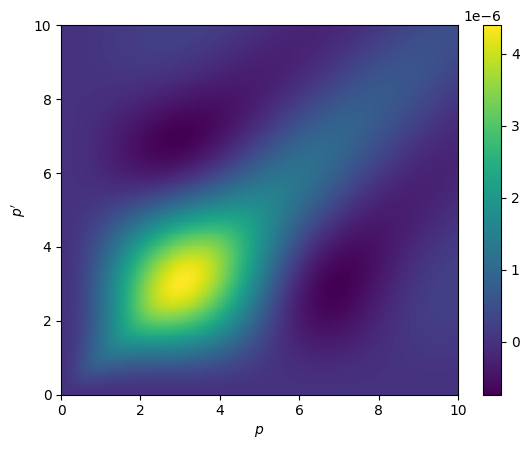

In [14]:
num_pts = 400
k_arr = np.linspace(0., 20., num_pts)
Vp = np.zeros((num_pts, num_pts))

import scipy.linalg as spla
for j, kk in enumerate(k_arr):
    for i, k in enumerate(k_arr):
        Vp[i, j] = chiralms(k, kk, channel, use_default_lec_values=True, **potentialArgs["kwargs"])
fig, ax = plt.subplots(1,1)
out = ax.pcolormesh(k_arr, k_arr, Vp) # , shading='gouraud')
# ax.imshow(Vp)
ax.set_xlabel("$p$")
ax.set_ylabel("$p'$")
ax.set_xlim(0,10)
ax.set_ylim(0,10)
_ = fig.colorbar(out)
# fig.savefig("minnesota_parameter_space_partition_sval.png", dpi=200)

In [17]:
np.max(np.abs((Vp - Vp.T)))

np.float64(0.0)